# Overview

1. Initial setup

    1.1 Import packages

    1.2 Import files and merge
2. Exploratory data analysis 

    2.1 Identify categorical and numerical features   

    2.2 Evaluate class imbalance

    2.3 Evaluate feature distributions

    2.4 Evaluate correlated features

    
3. Categorical preprocessing 

    3.1 Identifying cardinality of features 

    3.2 Applying label encoding to low cardinality features 

    3.3 Apply target encoding to high cardinality features
4. Feature engineering 

    4.1 Enrich date time related variables 

    4.2 Update columns

    4.3 Identify columns with correlation to isFraud

    4.4 Update columns, removing low correlation features  

    4.5 Save preprocessing info 

5. Training and classification

    5.1 Set parameters and train model

    5.2 Evaluate model


# 1. Initial setup

### 1.1 Import packages

In [6]:
import pandas as pd
import pickle as pkl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency

### 1.2 Import files and merge

In [8]:
# directory for model info files for saving: ./preprocess_info
# dictionary preprocess_info will contain the following information generated in this script, needed for classification/testing
# note, we have, at the end, already safeBank_lightGBM_model.txt ready to to in the folder

# Define the preprocess_info dictionary
preprocess_info = {}

In [9]:
# Load dataset

trainTransaction = pd.read_csv('datasets_initial/train_transaction.csv')
trainIdentity = pd.read_csv('datasets_initial/train_identity.csv')

# merge dataset
##merge on TransactionID 
trIdTr_base = pd.merge(trainTransaction, trainIdentity, on='TransactionID', how='left')

In [10]:
# OPTIONAL: , save to pkl and then load 

# trIdTr_base.to_pickle('./datasets_initial/trIdTr_base.pkl')

# Variable now is: trIdTr 
# # Open the pickle file in read-binary mode
# with open('./datasets_initial/trIdTr_base.pkl', 'rb') as file:
#     trIdTr = pkl.load(file)

# 2. Exploratory data analysis 

The dataset I am using is from https://www.kaggle.com/c/ieee-fraud-detection/overview.

You can find more information about the features here: https://www.kaggle.com/c/ieee-fraud-detection/data

### 2.1 Identify categorical and numerical features 

In [14]:
# Get the list of column names
columns_list = list(trIdTr.columns)


############ NEEDED FOR test data ###################################################### Save the column names to a text file
preprocess_info['trIdTr_initial_columns'] = columns_list

In [15]:
############ Save initial categorical features to dictionary
# Categorical features
categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'DeviceType', 'DeviceInfo',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 
    'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 
    'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 
    'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

In [16]:
############ Save numerical features to dictionary
# Numerical features (excluding TransactionID and isFraud)
numerical_features = [
    col for col in trIdTr.columns if col not in categorical_features
]

#  + ['TransactionID', 'isFraud']

In [17]:

numerical_features

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V8

In [19]:
# Add categorical features to the dictionary
preprocess_info['categorical_features'] = categorical_features

# Add numerical features to the dictionary

numerical_features_test = [
    col for col in trIdTr.columns if col not in categorical_features 
]

# + ['TransactionID', 'isFraud']

preprocess_info['numerical_features'] = numerical_features_test

### 2.2 Evaluate class imbalance

The dataset is highly imbalanced, with the target variable being only 3.5% of the dataset. This means we will have to work with a class imabalance.

- Not fraud: 96.5%

- Fraud: 3.5%

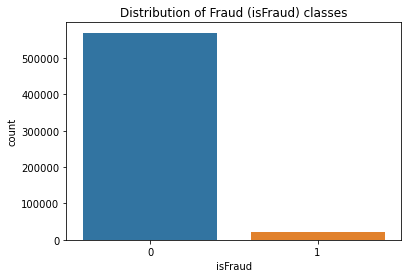

In [1]:
from IPython.display import display, Image

# Display the image
display(Image(filename='distribution_isfraud.png'))

### 2.3 Evaluate feature distributions

The majority of the variables present are not normally distributed, and some have outliers. Many are skewed left or right. A handful (e.g. D9) are cyclical. 

Since the distributions are not normal, we cannot easily use scalers (due to outliers and skewed distributions). This is also not great for linear models which rely on normal distributions. Furthermore, should we encounter any missing values in the dataset (NaN), filling with 0 may negatively impact model performance if 0 is not a natural or frequent value in the distribution.

To account for this issue, I am using a tree-based, gradient boosting model, LightGBM. Tree-based methods can handle non-normal distributions and don't require scalers.

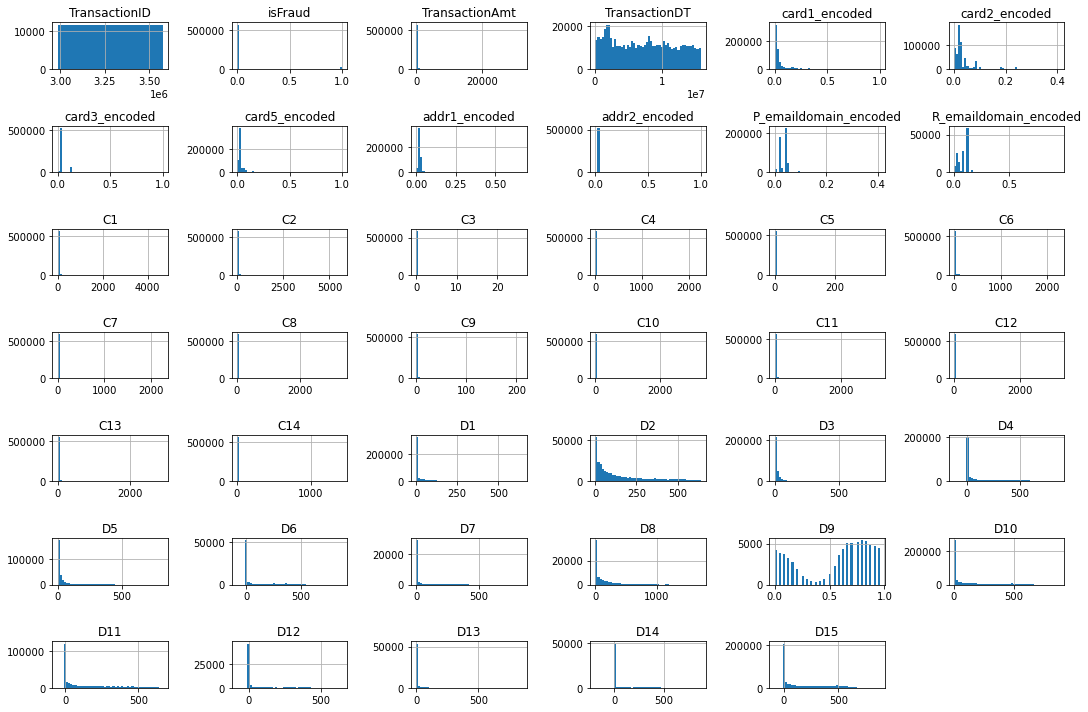

In [2]:
from IPython.display import display, Image

# Display the image
display(Image(filename='features_distributions.png'))

### 2.4 Evaluate correlated features

Some features are highly correlated with each other. This means, that these features are essentially identical, in terms of ability to predict fraud. 

To reduce the complexity of the model, which helps to reduce noise, we will (later on) remove features which are correlated with each other,. We will also remove features which are NOT or have low correlation with the target variable, isFraud, which has the same effect. If some variables don't explain much of the variation in the presence of fraud, they only create noise. 



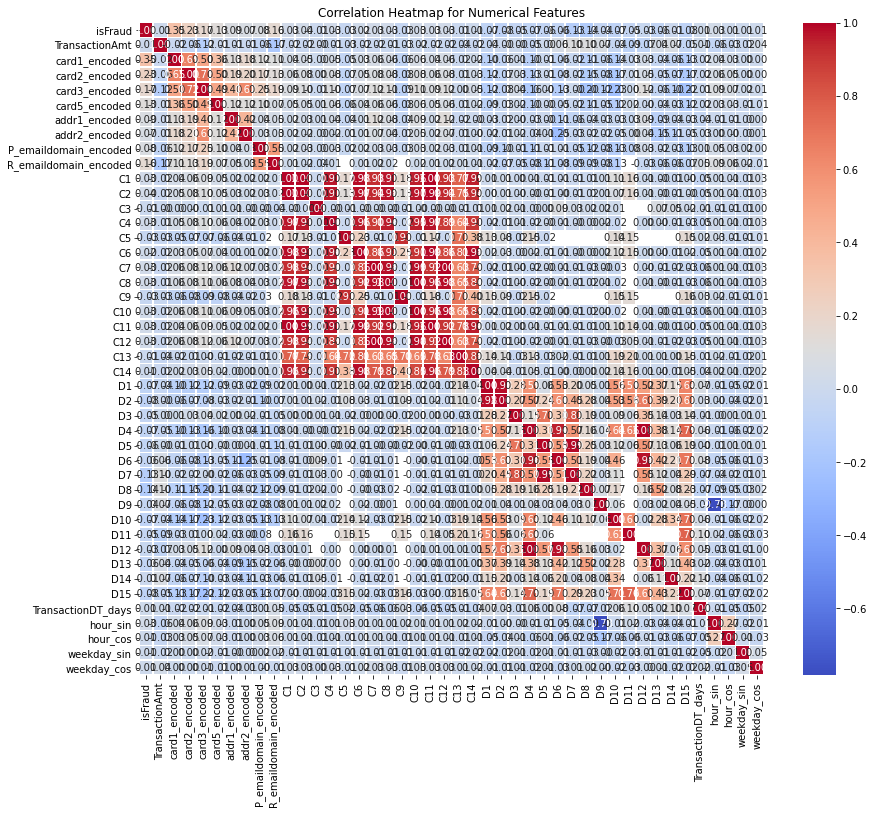

In [3]:
from IPython.display import display, Image

# Display the image
display(Image(filename='correlations.png'))

# 3. Categorical preprocessing 

Now, we must encode the categorical features, i.e. change them from strings (letters, words) to numbers. The model will not be able to read strings (letters or words) otherwise. 

###  3.1 Identifying cardinality of features 


We identify the cardinality of categorical features to determine which type of encoding to use (label vs target encoding )

In [20]:
# Calculate cardinality for categorical features
cardinality = {col: trIdTr[col].nunique() for col in categorical_features}
print("Cardinality of categorical features:", cardinality)

# Define a threshold for high cardinality
high_cardinality_threshold = 20  # Features with more than 20 unique categories are considered high cardinality

# Split the categorical features into low and high cardinality
low_cardinality_features = [col for col, unique_vals in cardinality.items() if unique_vals <= high_cardinality_threshold]
high_cardinality_features = [col for col, unique_vals in cardinality.items() if unique_vals > high_cardinality_threshold]

# Save the results in preprocess_info dictionary
preprocess_info['low_cardinality_features'] = low_cardinality_features
preprocess_info['high_cardinality_features'] = high_cardinality_features

Cardinality of categorical features: {'ProductCD': 5, 'card1': 13553, 'card2': 500, 'card3': 114, 'card4': 4, 'card5': 119, 'card6': 4, 'addr1': 332, 'addr2': 74, 'P_emaildomain': 59, 'R_emaildomain': 60, 'M1': 2, 'M2': 2, 'M3': 2, 'M4': 3, 'M5': 2, 'M6': 2, 'M7': 2, 'M8': 2, 'M9': 2, 'DeviceType': 2, 'DeviceInfo': 1786, 'id_12': 2, 'id_13': 54, 'id_14': 25, 'id_15': 3, 'id_16': 2, 'id_17': 104, 'id_18': 18, 'id_19': 522, 'id_20': 394, 'id_21': 490, 'id_22': 25, 'id_23': 3, 'id_24': 12, 'id_25': 341, 'id_26': 95, 'id_27': 2, 'id_28': 2, 'id_29': 2, 'id_30': 75, 'id_31': 130, 'id_32': 4, 'id_33': 260, 'id_34': 4, 'id_35': 2, 'id_36': 2, 'id_37': 2, 'id_38': 2}


### 3.2 Applying label encoding to low cardinality features 

In [21]:
# Create label Encoding for low cardinality features features

encoders = {}  # Initialize a dictionary to hold encoders

for col in low_cardinality_features:
    if trIdTr[col].dtype == 'object' or col in low_cardinality_features:
        le = LabelEncoder()
        trIdTr[col] = le.fit_transform(trIdTr[col].astype(str))
        encoders[col] = le  # Save the encoder for each column

# Save encoders in preprocess_info dictionary
preprocess_info['label_encoders'] = encoders

In [22]:
label_encoders = preprocess_info['label_encoders']

In [24]:
# example of how the label encoder works 

feature = 'ProductCD'
le = label_encoders.get(feature)

if le:
    print(f"Classes for {feature}: {le.classes_}")
    print(f"Mapping for {feature}: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    print(f"Label encoder for {feature} not found.")

Classes for ProductCD: ['C' 'H' 'R' 'S' 'W']
Mapping for ProductCD: {'C': 0, 'H': 1, 'R': 2, 'S': 3, 'W': 4}


### 3.3 Apply target encoding to high cardinality features

In [ ]:
# Target encoding for high cardinality features

In [ ]:
# Perform target encoding for high-cardinality features
# Ensure 'isFraud' is present
assert 'isFraud' in trIdTr.columns, "The 'isFraud' target column is missing."

# Dictionary to store target encoding mappings for each high cardinality feature
target_encodings = {}

for col in high_cardinality_features:
    # Initialize target encoded column
    trIdTr[f'{col}_target_enc'] = np.nan
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Dictionary to store the mapping for each high cardinality feature
    encoding_map = {}
    
    for train_idx, val_idx in skf.split(trIdTr, trIdTr['isFraud']):
        train_data, val_data = trIdTr.iloc[train_idx], trIdTr.iloc[val_idx]
        
        # Compute target encoding (mean of 'isFraud' for each category)
        means = train_data.groupby(col)['isFraud'].mean()
        
        # Map the target encoding to the validation set
        trIdTr.loc[val_idx, f'{col}_target_enc'] = val_data[col].map(means)
        
        # Save the encoding map for each category in the training data
        encoding_map[col] = means.to_dict()
    
    # Store the encoding map for each feature
    target_encodings[col] = encoding_map

# Save the target encodings dictionary to the preprocess_info dictionary
preprocess_info['target_encodings'] = target_encodings

In [36]:
trIdTr.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_17_target_enc', 'id_19_target_enc', 'id_20_target_enc',
       'id_21_target_enc', 'id_22_target_enc', 'id_25_target_enc',
       'id_26_target_enc', 'id_30_target_enc', 'id_31_target_enc',
       'id_33_target_enc'],
      dtype='object', length=455)

# 4. Feature engineering 

### 4.1 Enrich date time related variables 

TransactionDT variable is a time-delta variable that is a time from a given start point. Deriving additional columns related to time will help to capture time-related pattterns that are not otherwise captured by the time-delta TransactionDT feature.

In [ ]:
### add in TransactionDT enriched columns:

### numerical 
trIdTr['TransactionDT_days'] = trIdTr['TransactionDT'] // (24 * 60 * 60)  # Convert to days 

### categorical

trIdTr['TransactionDT_weekday'] = trIdTr['TransactionDT_days'] % 7  # Day of the week (0-6)
trIdTr['TransactionDT_hour'] = (trIdTr['TransactionDT']//3600) % 24  # Calculate hour of the day (0-23)

### numerical
trIdTr['TransactionDT_hours'] = (trIdTr['TransactionDT'] // (60 * 60)) % 24  # Extract hours - hours since reference point in dataset

trIdTr['hour_sin'] = np.sin(2 * np.pi * trIdTr['TransactionDT_hour'] / 24)
trIdTr['hour_cos'] = np.cos(2 * np.pi * trIdTr['TransactionDT_hour'] / 24)
trIdTr['weekday_sin'] = np.sin(2 * np.pi * trIdTr['TransactionDT_weekday'] / 7)
trIdTr['weekday_cos'] = np.cos(2 * np.pi * trIdTr['TransactionDT_weekday'] / 7)



I've further enriched the transaction amount column to allow for patterns in specific cent and dollar amounts. Patterns in transaction amount may not be fully represented by transaction amount on its own, but may be present if cents and dollars are separated. 

In [ ]:
####    TransactionAmt split into whole dollars and cents (so one dollars/whole number, and one cents column)
trIdTr['TransactionAmt_dollars'] = trIdTr['TransactionAmt'] // 1  # Extract whole dollars
trIdTr['TransactionAmt_cents'] = (trIdTr['TransactionAmt'] * 100) % 100  # Extract cents

### 4.2 Update columns

In [37]:

### categorical_features
### numerical_features , 

# Update categorical_features with newly created categorical columns
categorical_features += [
    'TransactionDT_weekday', 'TransactionDT_hour',  # New categorical features
]

# Update numerical_features with newly created numerical columns
numerical_features += [
    'TransactionDT_days', 'TransactionDT_hours',  # Existing numerical features
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',  # Cyclical features
    'TransactionAmt_dollars', 'TransactionAmt_cents',  # New features from TransactionAmt
    'DeviceInfo_target_enc', 'id_30_target_enc', 'id_25_target_enc', 'id_31_target_enc', 
    'id_20_target_enc', 'addr2_target_enc', 'card5_target_enc', 'card2_target_enc', 
    'addr1_target_enc', 'id_13_target_enc', 'id_19_target_enc', 'id_21_target_enc', 
    'card3_target_enc', 'id_17_target_enc', 'P_emaildomain_target_enc', 'id_33_target_enc', 
    'id_22_target_enc', 'id_26_target_enc', 'R_emaildomain_target_enc', 'card1_target_enc',
    'DeviceInfo_target_enc', 'id_30_target_enc', 'id_25_target_enc', 'id_31_target_enc', 
    'id_20_target_enc', 'addr2_target_enc', 'card5_target_enc', 'card2_target_enc', 
    'addr1_target_enc', 'id_13_target_enc', 'id_19_target_enc', 'id_21_target_enc', 
    'card3_target_enc', 'id_17_target_enc', 'P_emaildomain_target_enc', 'id_33_target_enc', 
    'id_22_target_enc', 'id_26_target_enc', 'R_emaildomain_target_enc', 'card1_target_enc', 
    'id_14_target_enc'
]

# Check the final lists
print("Updated categorical features:", categorical_features)
print("Updated numerical features:", numerical_features)

### note TransactionDT_hours,TransactionDT_days, are not important features so should not be put into either numieracl or categorerial (but still remain in dataset)

### find set which are not in either

# Get all columns from the dataframe
all_columns = set(trIdTr.columns)

# Combine categorical and numerical features
all_features = set(categorical_features + numerical_features)

# Identify features that are not in either categorical or numerical lists
missing_features = all_columns - all_features

# Print the missing features
print("Features not included in either categorical or numerical features:", missing_features)

# check that all columns are in categorical_features or numerical_features; if not, remove column, print removed column names. 
# exclusions are: 'Unnamed: 0', 'isFraud', 'TransactionID' #

# Remove target-encoded features from categorical_features if they exist in numerical_features (target encoded have become numerical now)
categorical_features = [col for col in categorical_features if col + '_target_enc' not in numerical_features]

# Remove TransactionDT_hours and TransactionDT_days from numerical_features
numerical_features = [col for col in numerical_features if col not in ['TransactionDT_hours', 'TransactionDT_days']]

# Create a set of all columns that should be included
all_columns = set(categorical_features + numerical_features)

# Exclude specific columns from being considered
excluded_columns = {'Unnamed: 0', 'isFraud', 'TransactionID'}

# Remove any columns from the dataframe that are not in the updated feature sets
removed_columns = []
for col in trIdTr.columns:
    if col not in all_columns and col not in excluded_columns:
        removed_columns.append(col)
        trIdTr.drop(col, axis=1, inplace=True)

# Print the names of removed columns
print("Removed columns:", removed_columns)

# Verify that all remaining columns are accounted for
remaining_columns = set(trIdTr.columns)
assert all(col in all_columns or col in excluded_columns for col in remaining_columns), "Some columns are not in either feature list!"

# Remove 'TransactionDT' and 'TransactionAmt' from numerical_features
numerical_features = [col for col in numerical_features if col not in ['TransactionDT', 'TransactionAmt']]

# Drop 'TransactionDT' and 'TransactionAmt' from the DataFrame
trIdTr.drop(['TransactionDT', 'TransactionAmt'], axis=1, inplace=True)

# create copy
trIdTr2 = trIdTr.copy()

Updated categorical features: ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDT_weekday', 'TransactionDT_hour']
Updated numerical features: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V2

 ###   4.3 Identify columns with correlation to isFraud


As explained above, features with low correlation to isFraud may cause undue noise.

In [46]:
# Check correlation for numerical features with 'isFraud' (using Pearson's correlation)
numerical_corr = trIdTr2[numerical_features].corrwith(trIdTr2['isFraud']).sort_values(ascending=False)
print("Numerical Features Correlation with isFraud:")
print(numerical_corr)

# Set a threshold for weak correlation (e.g., below 0.1 or -0.1)
low_correlation_features = numerical_corr[abs(numerical_corr) < 0.1].index

# Print features to be removed
print(f"Features with low correlation (removed): {low_correlation_features}")

# Save the low correlation features list to the preprocess_info dictionary
preprocess_info['low_correlation_features'] = list(low_correlation_features)

Numerical Features Correlation with isFraud:
isFraud             1.000000
id_25_target_enc    0.522282
id_25_target_enc    0.522282
id_25_target_enc    0.522282
id_25_target_enc    0.522282
                      ...   
V49                -0.110920
V48                -0.115786
id_01              -0.120099
D7                 -0.127199
D8                 -0.142636
Length: 254, dtype: float64
Features with low correlation (removed): Index([], dtype='object')


### 4.4 Update columns, removing low correlation features  

In [47]:
# Remove features with low correlation
numerical_features = [feature for feature in numerical_features if feature not in low_correlation_features]

In [49]:
## update trIdTr2 to include features only needed:

# Define the columns to include
included_columns =  numerical_features + categorical_features
# ['isFraud', 'TransactionID'] +

# 'Unnamed: 0',

# Update trIdTr2 by selecting only the desired columns
trIdTr2 = trIdTr2[included_columns]

# Print the shape of the updated dataframe
print(f"Updated dataframe shape: {trIdTr2.shape}")

#create copy
trIdTr3 = trIdTr2.copy()

Updated dataframe shape: (590540, 420)


In [51]:
trIdTr3

,isFraud,D7,D8,V15,V16,V17,V18,V21,V22,V23,...,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,TransactionDT_weekday,TransactionDT_hour
0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,1,0
1,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,1,0
2,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,1,0
3,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,1,0
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,3,3,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,0,23
590536,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,0,23
590537,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,0,23
590538,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,2,4,4,2,2,2,2,0,23


In [52]:
# Identify duplicated columns
duplicate_columns = trIdTr3.columns[trIdTr3.columns.duplicated()]

# Log the duplicated columns
print(f"Duplicated columns: {duplicate_columns.tolist()}")

# Drop duplicate columns
trIdTr3 = trIdTr3.loc[:, ~trIdTr3.columns.duplicated()]

Duplicated columns: ['DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'DeviceInfo_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_30_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_25_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_31_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'id_20_target_enc', 'card5_target_enc', 'card5_target_enc', 'card5_target_enc', 'card5_target_enc', 'card5_target_enc', 'card5_target_enc', 'card5_target_enc', 'card2_target_enc', 'card2_target_enc', 'card2_target_enc', 'card2_target_enc', 'card2_target_enc', 'car

###     4.5 Save preprocessing info 

In [53]:
# Print the shape of the updated dataframe
print(f"Updated dataframe shape: {trIdTr3.shape}")

Updated dataframe shape: (590540, 165)


In [54]:
# Save the final list of columns to the dictionary for later use in the test preprocessing script
preprocess_info['final_columns'] = list(trIdTr3.columns)

In [55]:

preprocess_info.keys()

dict_keys(['trIdTr_initial_columns', 'categorical_features', 'numerical_features', 'low_cardinality_features', 'high_cardinality_features', 'label_encoders', 'target_encodings', 'low_correlation_features', 'final_columns'])

In [56]:
######################### Save shapes before and after preprocessing ##########################
# Training
preprocess_info['train_before_shape'] = trIdTr.shape
preprocess_info['train_after_shape'] = trIdTr3.shape

# Save columns before and after preprocessing for training
preprocess_info['train_columns_before'] = trIdTr.columns.tolist()
preprocess_info['train_columns_after'] = trIdTr3.columns.tolist()

# For training
train_columns_removed = [col for col in preprocess_info['train_columns_before'] if col not in preprocess_info['train_columns_after']]
train_columns_added = [col for col in preprocess_info['train_columns_after'] if col not in preprocess_info['train_columns_before']]

# Save the differences to the dictionary
preprocess_info['train_columns_removed'] = train_columns_removed
preprocess_info['train_columns_added'] = train_columns_added

In [57]:
# Save the preprocess_info dictionary to a pickle file
with open('./preprocess_info/preprocess_info.pkl', 'wb') as f:
    pkl.dump(preprocess_info, f)

# 5. Training and classification

###    5.1 Set parameters and train model



In [ ]:
## set up parameter and train
### special note: early_stopping and log_evaluation should be callbacks 
### we use stratifiedKfold to reduce effect of imbalanced classsee 

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare the features and target
X = trIdTr3.drop(columns=['isFraud', 'Unnamed: 0', 'TransactionID'])
y = trIdTr3['isFraud']

# Set up StratifiedKFold (5-fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Set up LightGBM parameters
params = {
    'objective': 'binary',             # Binary classification
    'metric': 'auc',                   # Evaluation metric (AUC)
    'boosting_type': 'gbdt',           # Gradient Boosting Decision Tree
    'num_leaves': 31,                  # Number of leaves in one tree
    'learning_rate': 0.05,             # Learning rate
    'feature_fraction': 0.9,           # Fraction of features to be used in each iteration
    'bagging_fraction': 0.8,           # Fraction of data to be used in each iteration
    'bagging_freq': 5,                 # Frequency of bagging
    'verbose': -1                      # Suppress LightGBM output
}

# Early stopping and log evaluation callbacks
callbacks = [
    lgb.early_stopping(stopping_rounds=50),  # Stop if validation AUC does not improve for 50 rounds
    lgb.log_evaluation(period=10)            # Log the evaluation every 10 rounds
]

# Initialize variables to store the out-of-fold predictions and actual labels
oof_preds = np.zeros(X.shape[0])
roc_auc_scores = []

# Perform StratifiedKFold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Convert to LightGBM dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        num_boost_round=1000,                # Maximum number of boosting rounds
        callbacks=callbacks
    )

    # Make predictions on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Store the out-of-fold predictions
    oof_preds[val_idx] = y_pred
    
    # Calculate and print ROC AUC score for the fold
    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f"Fold {fold+1} ROC AUC: {roc_auc:.4f}")

# Calculate and print the average ROC AUC across all folds
avg_roc_auc = np.mean(roc_auc_scores)
print(f"\nAverage ROC AUC across all folds: {avg_roc_auc:.4f}")

In [ ]:
# Save the model to a file
model.save_model('safeBank_lightGBM_model.txt')

 ###  5.2 Evaluate model

The final lightGBM model has 93% (0.932) accuracy/ROC AUC (Receiver Operating Characteristic - Area Under the Curve) after validation. This is in line with several other public submissions for the competition (https://www.kaggle.com/c/ieee-fraud-detection/leaderboard).  

I do not have access to the IEEE-CIS Fraud Detection Dataset official test set, which was used in competition. However, even if my model was tested on this dataset, allowing for a 5% drop in my score, I would still have an ROC AUC of 0.88 approximately, in line with a bronze medal.

Examples: 
- Bronze: 0.885 private https://github.com/pritesh-shrivastava/kaggle-ieee-fraud-detection
- Silver: 0.938 private https://github.com/shejz/IEEE-CIS-Fraud-Detection


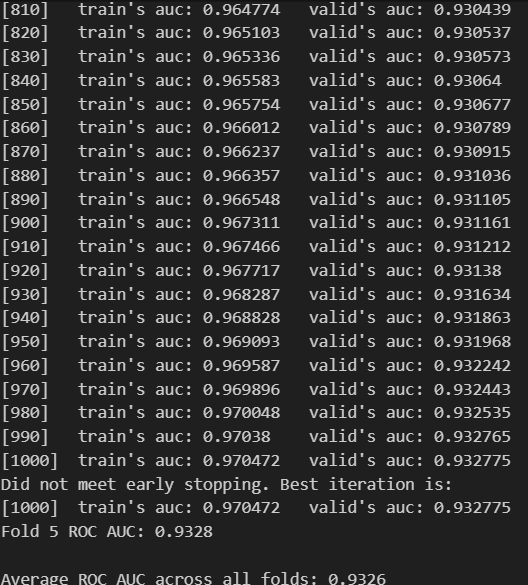

In [4]:
from IPython.display import display, Image

# Display the image
display(Image(filename='training_performance.png'))